In [1]:
import sys
from copy import deepcopy
import time

sys.path.append('../utils')
from pyutils import *

In [2]:
puzzle = readutf8('input.txt')
sample = readutf8('sample.txt')

In [62]:
from PIL import Image, ImageDraw, ImageColor
def heatmap(mat: StrMatrix, distances: dict[Pt, int], dmin: int, dmax: int,
        highlight: list[Pt] | None = None,
        out: tuple[int, int]=(-1, -1)
    ) -> Image.Image:
    highlight = highlight or []
    im = Image.new(size=(len(mat[0]), len(mat)), mode='RGB', color='black')
    brush = ImageDraw.Draw(im)
    for pt, val in mat_iter(mat):
        if val != '#':
            brush.point((pt[1], pt[0]), 'white')
        if pt in distances:
            perc = (distances[pt] - dmin) / (dmax - dmin)
            hue = int(120 * perc)
            brush.point((pt[1], pt[0]), f'hsv({hue}, 100%, 100%)')
    for pt in highlight:
        brush.point((pt[1], pt[0]), 'blue')
    if all(n > 0 for n in out):
        im = im.resize(out, resample=0)
        brush = ImageDraw.Draw(im)
    gridw = len(mat[0])
    gridh = len(mat)
    for pt, d in distances.items():
        x = pt[1] * (im.size[0] / gridw)
        y = pt[0] * (im.size[1] / gridh)
        # print(x, y, str(d))
        brush.text((x, y), str(d), fill='black')
    return im

In [63]:
def walk_maze(mat: StrMatrix, start_char: str, end_char: str):
    mat = deepcopy(mat)

    start_pt: Pt = Pt(-1, -1)
    end_pt: Pt = Pt(-1, -1)
    for pt, val in mat_iter(mat):
        if val == start_char:
            start_pt = Pt.of(pt)
        if val == end_char:
            end_pt = Pt.of(pt)
        if Pt(-1, -1) not in [start_pt, end_pt]:
            break

    assert(start_pt != Pt(-1, -1))
    assert(end_pt != Pt(-1, -1))

    visited: dict[Pt, int] = {}
    vertices: list[Pt] = [start_pt]
    segments: dict[Pt, list[Pt]] = {start_pt: []}
    pos = start_pt
    dirpt: Pt = Pt(0, 1)
    score: int = 0

    log: list[str] = ['...']
    def _next_branch(pos: Pt, vertex: Pt) -> bool | None:
        """
        Returns True if end was reached, False if wall was reached, None otherwise
        """
        nonlocal dirpt, score
    
        # time.sleep(0.1)
        # clear_output(wait=True)
        # display(heatmap(mat, visited, 0, end_pt.distance(start_pt), highlight=vertices))
        # print(log[-1])
        # print(f'Now: {pos} ; {dirpt}')
        # print(f'Score: {score}')
        # display(heatmap(mat, visited, 0, end_pt.distance(start_pt)).resize((400, 400), resample=0))
        # print(show_in_matrix(mat, *visited, col='white on blue', colmap={pos:'black on red'}))

        visited[pos] = pos.distance(start_pt)

        branches: list[Pt] = []
        for branch in Pt.cardinals():
            future = pos + branch
            if future in visited:
                continue
            val = matget(mat, future)
            if val == '#':
                continue
            branches.append(branch)

        if len(branches) > 1:
            vertices.append(pos)
            segments[pos] = []
            vertex = pos
            
        pos_is_vertex = pos == vertex

        for branch in branches:
            future = pos + branch
            if pos_is_vertex:
                segments[vertex].clear()
            segments[vertex].append(future)
            log.append(f'Checking branch: {branch} off of vertex {vertex}')
            if future == end_pt:
                visited[future] = future.distance(start_pt)
                log.append(f'{future}: is END')
                # return True
            if future in visited:
                log.append(f'{future}: visited')
                continue
            if matget(mat, pos + branch) == '#':
                log.append(f'{future}: is a wall')
                continue
            if dirpt != branch:
                diff = abs(Pt.cardinals().index(branch) - Pt.cardinals().index(dirpt))
                if diff == 2:
                    score += 2000
                if diff in [1, 3]:
                    score += 1000
            dirpt = branch
            if _next_branch(future, vertex) is True:
                return True
        segments[vertex].clear()
        if pos_is_vertex:
            log.append(f'{vertex} is out of branches')
            del segments[vertex]
        else:
            log.append('Out of branches')

    ret = _next_branch(pos, pos)
    successful: dict[Pt, int] = {}
    for k, v in segments.items():
        if k not in successful:
            successful[k] = visited[k]
        for pt in v:
            if pt not in successful:
                successful[pt] = visited[pt]
    display(heatmap(mat, visited, 0, end_pt.distance(start_pt), highlight=vertices, out=(600,600)))
    # display(heatmap(mat, {pt:d for pt, d in successful.items()}, 0, end_pt.distance(start_pt), highlight=vertices).resize((600, 600), resample=0))
    return ret, visited, log, successful

In [64]:
maze = strtomat(sample)

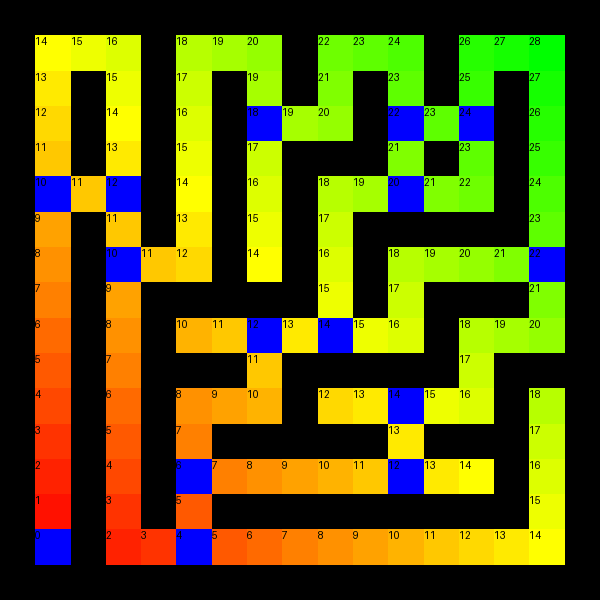

In [65]:
result = walk_maze(maze, 'S', 'E')

In [7]:
sum(result[3].values())

0

In [8]:
result[3]

{}

In [46]:
def dijkstra(mat: Matrix, start: Pt, end: Pt):
    def visualize():
        clear_output(wait=True)
        im = Image.new(size=(len(mat[0]), len(mat)), mode='RGB', color='white')
        brush = ImageDraw.Draw(im)
        for pt, val in mat_iter(mat):
            if val == '#':
                brush.point((pt[1], pt[0]), 'black')
            if pt in visited:
                brush.point((pt[1], pt[0]), 'green')
        brush.point((start[1], start[0]), 'cyan')
        brush.point((end[1], end[0]), 'magenta')
        display(im)
        # display(im.resize((300,300), resample=0))

    pos = start
    active_nodes: list[Pt] = [start]
    visited: list[Pt] = []

    while True:
        # time.sleep(0.01)
        visualize()
        for node in active_nodes:
            visited.append(node)
            for direc in Pt(-1, 0), Pt(0, 1), Pt(1, 0), Pt(0, -1):
                if node + direc in visited:
                    continue
                if matget(mat, node + direc) == '#':
                    continue
                active_nodes.append(node + direc)
            active_nodes.remove(node)

In [47]:
dijkstra(strtomat(puzzle), Pt(15, 1), Pt(1, 15))

KeyboardInterrupt: 